In [37]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer,PolynomialFeatures



from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# MODELS
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


In [3]:
# NEED TO CHECK WHETHER IT MAKES SENSE TO JUST RUN INDIVIDUAL MODELS BY STATE OR EVEN CITY
# IS THE BOOST TO ACCURACY SIGNIFICANT? DOES THE POTENTIAL COST OF TRAINING OUTWEIGH BENEFITS?


# MODEL CONSIDERATIONS

# LOCAL REGRESSION FOR PAIR VARIABLES LAT/LON IN ADDITION TO SPLINE
# VARYING COEFFICIENT MODEL COULD WORK FOR DAYS ON MARKET ;; ISSUE: NOT A PREDICTIVE VARIABLE FOR USER INPUT

In [20]:
aws_bucket=os.getenv('AWS_RE_BUCKET')
aws_key=os.getenv('AWS_RE_BUCKET_KEY')
aws_secret=os.getenv('AWS_RE_BUCKET_SECRET')

date="2023-06-04"
state="CA"
states=['AL',
 'NE',
 'AK',
 'NV',
 'AZ',
 'NH',
 'AR',
 'NJ',
 'CA',
 'NM',
 'CO',
 'NY',
 'CT',
 'NC',
 'DE',
 'ND',
 'DC',
 'OH',
 'FL',
 'OK',
 'GA',
 'OR',
 'HI',
 'PA',
 'ID',
 'PR',
 'IL',
 'RI',
 'IN',
 'SC',
 'IA',
 'SD',
 'KS',
 'TN',
 'KY',
 'TX',
 'LA',
 'UT',
 'ME',
 'VT',
 'MD',
 'VA',
 'MA',
 'VI',
 'MI',
 'WA',
 'MN',
 'WV',
 'MS',
 'WI',
 'MO',
 'WY',
 'MT',
]

In [31]:
# PULLING IN DATA

df_list=[]
for st in states:
    try:
        df = pd.read_parquet(path=aws_bucket+f"/{date}/{st}.parquet",storage_options={"key":aws_key,"secret":aws_secret})
        df_list.append(df)
    except:
        pass
    
df=pd.concat(df_list)

In [49]:
""" NEEDS TO BE MODIFIED

# PREPROCESSING
prop_types=['Single Family Residential', 'Mobile/Manufactured Home','Townhouse', 'Multi-Family (2-4 Unit)', 'Condo/Co-op','Multi-Family (5+ Unit)']


df=df.applymap(lambda x: np.nan if x=='nan' else x)

df_copy=df.copy()

df=df[['CITY','STATE OR PROVINCE','PROPERTY TYPE','PRICE','BEDS','BATHS','SQUARE FEET','YEAR BUILT','DAYS ON MARKET','LATITUDE','LONGITUDE']].dropna(axis=0).reset_index(drop=True).apply(lambda row: pd.to_numeric(row,errors='ignore'))

df=df[df['PROPERTY TYPE'].isin(prop_types)]

temp=pd.get_dummies(data=df['PROPERTY TYPE'])

df_full=pd.concat([df,temp],axis=1)

df_final=df_full.drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE'],axis=1)

df_final=df_final[df_final['Single Family Residential']==1] # TEMP LIMITER


# PREPROCESSING PIPELINE

# 1 CONVERT CATEGORICAL PROEPRTY TYPE TO DUMMIES
# 2 FOR RADIAL VALUES (LAT, LON, INTERACTION) NEED TO SPLIT INTO GRADIENTS
# 3 INCORPORATE POLYNOMIAL INTERACTION AMONG SPLIT FEATURES



for train_idx,test_idx in KFold(n_splits=5).split(df_final):
    train,test=df_final.iloc[train_idx],df_final.iloc[test_idx]
    r2s=[]
    rsmses=[]
    for k in range(1,100):
            
            # Define the transformations for each column
            preprocessor = ColumnTransformer(
            transformers=[
                ('cubic_spline',SplineTransformer(k,degree=3,include_bias=False,extrapolation='periodic'), ['LATITUDE','LONGITUDE']),
                ('cubic_features', PolynomialFeatures(degree=3, include_bias=False), ['LATITUDE', 'LONGITUDE'])
            ])
            # Apply the transformations in a pipeline
            pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
            lat_lon_transformed = pipeline.fit_transform(train)
            
            train_arr=train.drop(['LATITUDE',"LONGITUDE"],axis=1).to_numpy()
            
            X_train_np=np.concatenate(train_arr,lat_lon_transformed)
            y_train_np=train['PRICE'].to_numpy()
            
            lr = LR()
            lr.fit(X_train_np[:,1:],y_train_np)
            y_pred = lr.predict(test.drop(['PRICE'],axis=1))
            
            y_test=test['PRICE']
            
            r2=r2_score(y_test,y_pred)
            
            rmse=np.sqrt(mean_squared_error(y_test,y_pred))
            
"""
            
    
            
            
            
            


KeyboardInterrupt: 

In [91]:
for train_idx,test_idx in KFold(n_splits=10).split(df_final):
    train,test=df_final.iloc[train_idx],df_final.iloc[test_idx]
    r2s=[]
    rsmses=[]# Define the transformations for each column
    preprocessor = ColumnTransformer(
    transformers=[
        ('cubic_spline',SplineTransformer(100,degree=3,include_bias=False,extrapolation='periodic'), ['LATITUDE','LONGITUDE']),
        ('cubic_features', PolynomialFeatures(degree=3, include_bias=False), ['LATITUDE', 'LONGITUDE'])
    ])
    # Apply the transformations in a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    lat_lon_train_transformed = pipeline.fit_transform(train)
    lat_lon_test_transformed = pipeline.fit_transform(test)

    train_arr=train.drop(['LATITUDE',"LONGITUDE"],axis=1).to_numpy()

    X_train_np=np.concatenate([train_arr,lat_lon_train_transformed],axis=1)
    y_train_np=train['PRICE'].to_numpy()

    lr = LR()
    lr.fit(X_train_np[:,1:],y_train_np)
    
    test_arr=test.drop(['LATITUDE','LONGITUDE'],axis=1).to_numpy()
    
    X_test_np=np.concatenate([test_arr,lat_lon_test_transformed],axis=1)
    y_test_np=test['PRICE'].to_numpy()
    
    y_pred = lr.predict(X_test_np[:,1:])

    r2=r2_score(y_test_np,y_pred)

    rmse=np.sqrt(mean_squared_error(y_test_np,y_pred))

In [105]:
r2

-163633758.08059126

In [95]:
df_slice=df_final[(df_full['PROPERTY TYPE']=='Single Family Residential') & (df_full['CITY']=='Houston')]

X_train,X_test,y_train,y_test=train_test_split(df_slice.drop(['PRICE','LATITUDE','LONGITUDE'],axis=1).iloc[:,:5],df_slice['PRICE'],test_size=.25,random_state=100)

lr = LR()

lr.fit(X_train,y_train)

pred = lr.predict(X_test)

print("R2: ",r2_score(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

13421718095.935127

In [12]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

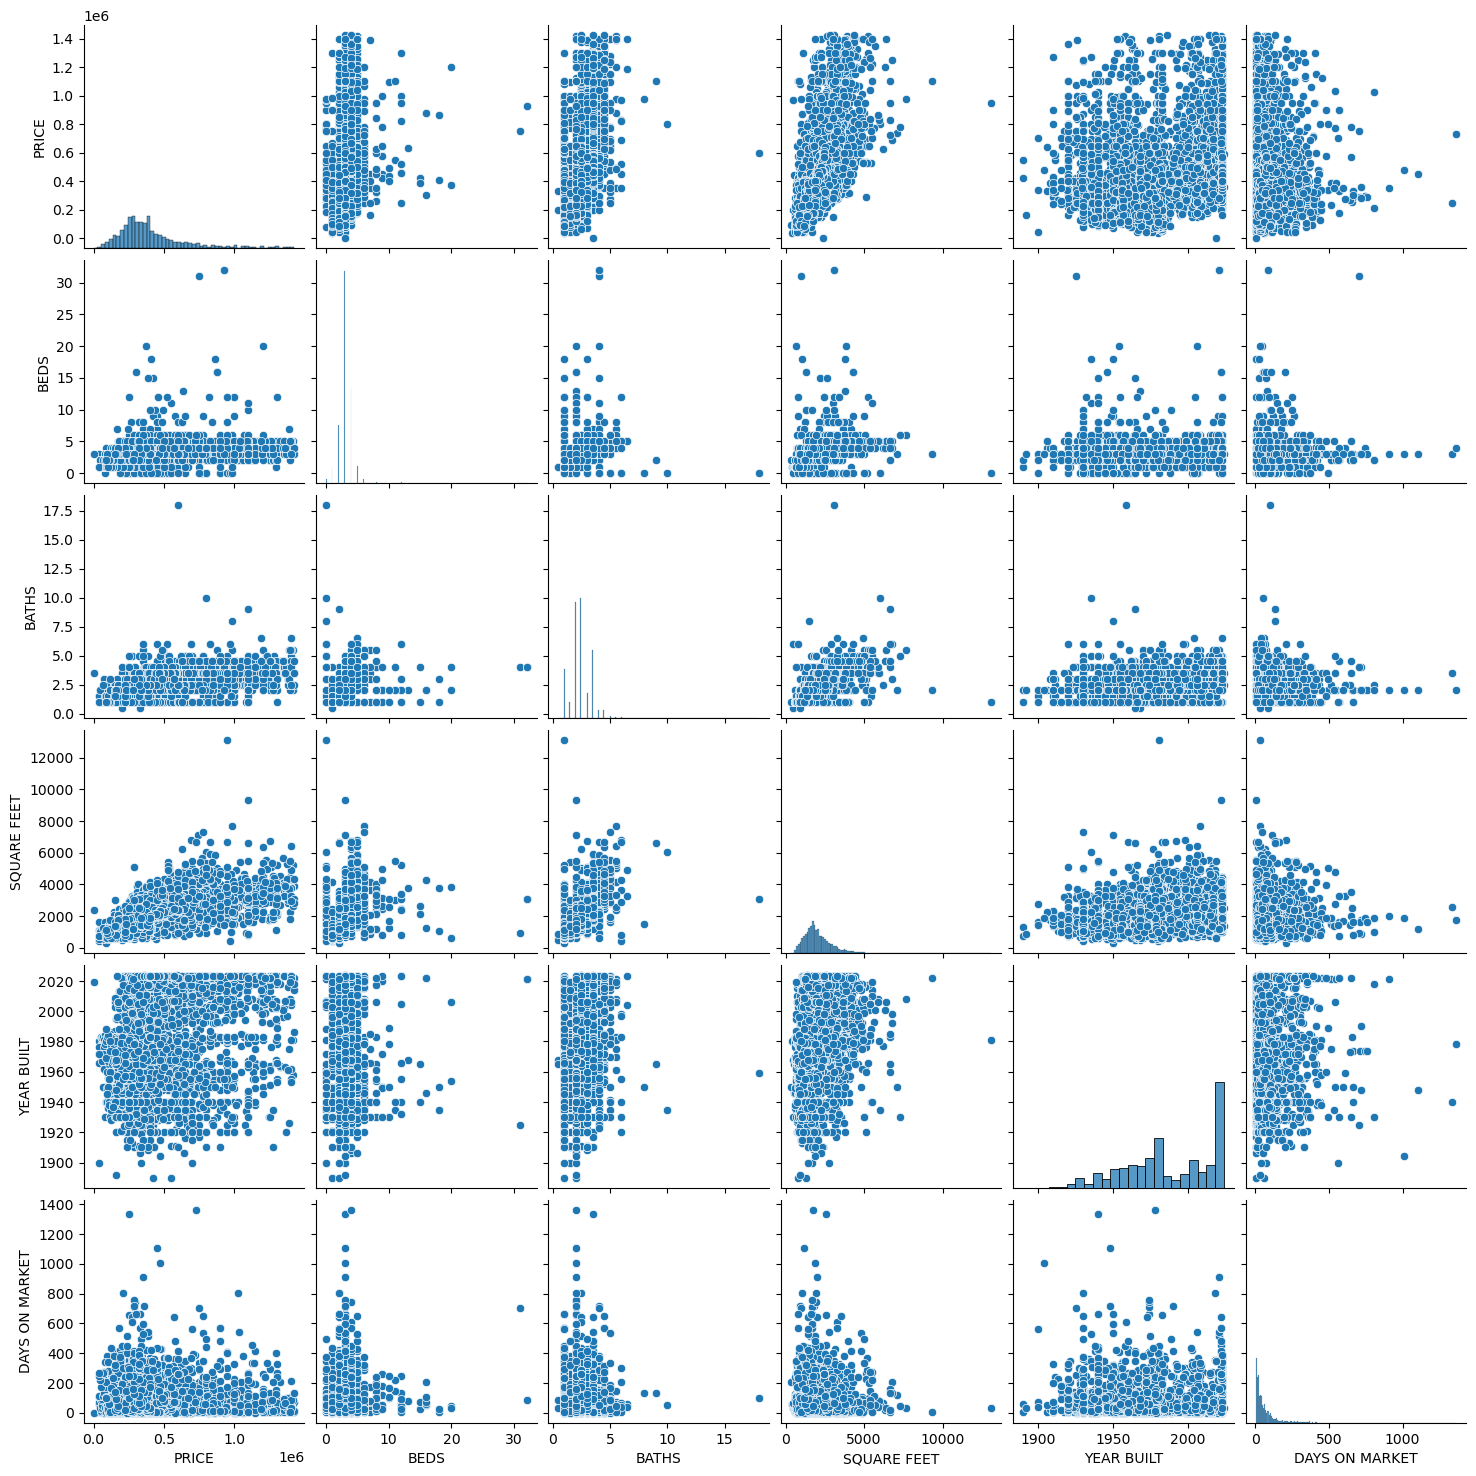

In [35]:
df_visual=df.drop(['LONGITUDE','LATITUDE'],axis=1)

df_visual=df_visual[~is_outlier(df_visual.drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE'],axis=1).to_numpy())]

sns.pairplot(df_visual[df_visual['CITY']=='Houston'])



In [14]:
df_final[df_final['PROPERTY TYPE']=='Single Family Residential'].drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE','PRICE','LATITUDE','LONGITUDE'],axis=1)


# NEED TO FIND WAY TO PENALIZE PREDICTION VALUE BY DAYS ON MARKET, HAS A POSITIVE COEF
# 

,BEDS,BATHS,SQUARE FEET,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,Condo/Co-op,Mobile/Manufactured Home,Multi-Family (2-4 Unit),Multi-Family (5+ Unit),Single Family Residential,Townhouse
0,4.0,2.0,2093.0,2003.0,1.0,21.0,0,0,0,0,1,0
1,3.0,2.0,1825.0,2011.0,2.0,50.0,0,0,0,0,1,0
2,4.0,2.0,2184.0,2023.0,11.0,30.0,0,0,0,0,1,0
3,3.0,2.0,1839.0,2023.0,12.0,30.0,0,0,0,0,1,0
4,4.0,3.5,3181.0,2018.0,14.0,50.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
198446,3.0,3.5,4529.0,2016.0,177.0,135.0,0,0,0,0,1,0
198448,4.0,3.0,3027.0,2023.0,177.0,30.0,0,0,0,0,1,0
198449,4.0,3.0,2560.0,2022.0,177.0,100.0,0,0,0,0,1,0
198451,3.0,2.0,2560.0,2022.0,177.0,100.0,0,0,0,0,1,0


R2:  0.6998351880483942
MAE:  318961.78069147957
MSE:  438086359696.91956


In [17]:
lr.coef_

array([-109274.46248966,  216455.8051669 ,     439.33560354,
         -5343.05096993,     750.65847514])

## END OF CURRENT PROGRESS FOR GRADIENT TRANSFORMATION INTO LINEAR MODEL

In [163]:
X_train,X_test,y_train,y_test=train_test_split(df_final.drop(['PROPERTY TYPE','CITY','STATE OR PROVINCE','PRICE'],axis=1),df_final['PRICE'],test_size=.25,random_state=101)


In [164]:
# Now try KNN to recommend comparables; may be best model you get if pricing model fails (clearly XGB ain't it)

### Start of XGBoost

In [165]:
# XGBoost not very successful; best R2_score at .63, but skyrockets MSE

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [166]:
dtrain.feature_names

['BEDS',
 'BATHS',
 'SQUARE FEET',
 'YEAR BUILT',
 'DAYS ON MARKET',
 'HOA/MONTH',
 'LATITUDE',
 'LONGITUDE',
 'Condo/Co-op',
 'Mobile/Manufactured Home',
 'Multi-Family (2-4 Unit)',
 'Multi-Family (5+ Unit)',
 'Single Family Residential',
 'Townhouse']

In [167]:
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmse'  # Evaluation metric: Root Mean Squared Error
}

In [168]:
num_rounds = 10  # Number of boosting rounds (iterations)
model = xgb.train(params, dtrain, num_rounds)

In [169]:
y_pred = model.predict(dtest)

In [170]:
y_pred

array([ 581947.9 , 1466473.5 ,  735871.1 , ...,  388180.  ,  467970.3 ,
        580419.44], dtype=float32)

In [172]:
print("R2: ",r2_score(y_test,y_pred))
print("MAE: ",mean_absolute_error(y_test,y_pred))
print("MSE: ",mean_squared_error(y_test,y_pred))

R2:  0.6003564958129752
MAE:  264457.0583785895
MSE:  1467809678671.4956


In [ ]:
grid.best_params_

# C: 700 ; D: 5
# C: 1000; D: 2

{'C': 700.0, 'degree': 5, 'kernel': 'poly'}